<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/vgg16_features_extraction_dogs_cats_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 # VGG16 features extraction
 
###Extract predictions of an existing model to train another model

- VGG16 is an image categories classifier trained over 1.4m samples from 1000 categories.

- We will use its base pre-trained model to extract features from datasets 
- We will use them to train a simple dense layers model.

- Fast and cheap way that avoid expensive training calculation.


In [ ]:
# VGG16 BASE MODEL

from keras.applications import VGG16

# We use imagenet weights
# We keep only the convnets part
# Top denses layers are not included
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()
     

In [3]:
# DATASET & PREPROCESSING - 4000 images of dogs/cats with cat labels
# 2000 img for train, 1000 img for validation, 1000 img for test


import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sys import path

def extract_features(directory, sample_count, batch_size, datagen, base_model):
  """
  Extract features of images by predicting them with a base model
  """

  # After convolution steps, img size is 4x4
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))

  # Init generator with data from directory
  generator = datagen.flow_from_directory(
      directory,
      target_size=(150, 150),
      batch_size=batch_size,
      class_mode='binary'
  )

  i = 0
  for inputs_batch, labels_batch in generator:
    
    # Predict to get the convnets features input
    features_batch = base_model.predict(inputs_batch)

    # Save features
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1

    # Generator will loop forever, we must break it
    if i * batch_size >= sample_count:
      break
    
  return features, labels


# Init generator
datagen = ImageDataGenerator(rescale=1./255)

# Define number of samples as batch
batch_size = 20

# Path where dataset should stand
base_dir = path[0] + "/drive/MyDrive/dog-cat-dataset/"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Features extraction for each dataset
train_features, train_labels = extract_features(
    train_dir, 
    2000, 
    batch_size, 
    datagen,
    conv_base
)

validation_features, validation_labels = extract_features(
    validation_dir, 
    1000, 
    batch_size, 
    datagen,
    conv_base
)

test_features, test_labels = extract_features(
    test_dir, 
    1000, 
    batch_size, 
    datagen,
    conv_base
)

# Flatten datasets
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step


In [4]:
# MODEL DEFINITION - the model should predict if img shows a dog or a cat 

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [5]:
# TRAINING - We will use extracted features from VGG16 as inputs

history = model.fit(train_features, train_labels,
              epochs=30,
              batch_size=20,
              validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 13ms/step - loss: 0.6029 - acc: 0.6670 - val_loss: 0.4478 - val_acc: 0.8300
Epoch 2/30
100/100 [==============================] - 1s 11ms/step - loss: 0.4363 - acc: 0.7960 - val_loss: 0.3633 - val_acc: 0.8670
Epoch 3/30
100/100 [==============================] - 1s 12ms/step - loss: 0.3575 - acc: 0.8450 - val_loss: 0.3225 - val_acc: 0.8800
Epoch 4/30
100/100 [==============================] - 1s 12ms/step - loss: 0.3178 - acc: 0.8695 - val_loss: 0.2993 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2905 - acc: 0.8855 - val_loss: 0.2894 - val_acc: 0.8930
Epoch 6/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2663 - acc: 0.8955 - val_loss: 0.2706 - val_acc: 0.8960
Epoch 7/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2501 - acc: 0.9020 - val_loss: 0.2622 - val_acc: 0.8990
Epoch 8/30
100/100 [==============================] - 1s 11ms/step - 

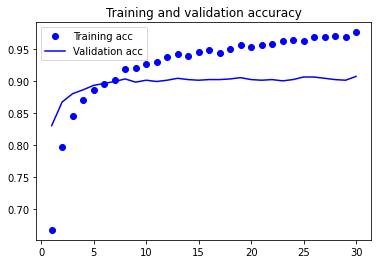

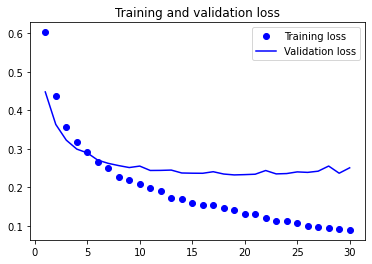

In [6]:
# LOG TRAINING RESULTS

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [7]:
# EVALUATION

score = model.evaluate(test_features, test_labels)
print(model.metrics_names)
print(score)

32/32 [==============================] - 0s 4ms/step - loss: 0.2626 - acc: 0.8850
['loss', 'acc']
[0.26259541511535645, 0.8849999904632568]
